## Amsterdam Refuse Analysis

This analysis uses public data accessible from the [Amsterdam Gemente Data API](https://api.data.amsterdam.nl/v1/docs/index.html). Data from the Containers and Weighing datasets are cleaned in Pandas and then visualized using Matplotlib. 

In [259]:
import requests
import pandas as pd
import waste_creds
from io import BytesIO
import csv
from pandas import json_normalize
import time
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
pd.options.mode.chained_assignment = None

## Data Cleaning

The data is cleaned in a number of steps. First missing values pertinent to the analyses and duplciate rows are located and dealt with. A variable with confusing categories is then cleaned using a function. Further cleaning particular to each analysis comes later. 

In [329]:
containerlocatie = pd.read_csv("containerlocatie.csv") # Load the datasets
container = pd.read_csv("container.csv")

In [330]:
container.info() # Info provides a quick way to understand what variables are in the dataset. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2007 entries, 0 to 2006
Data columns (total 41 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               2000 non-null   float64
 1   idNummer                         2000 non-null   object 
 2   serienummer                      2000 non-null   object 
 3   clusterId                        1451 non-null   object 
 4   eigenaarId                       2000 non-null   float64
 5   eigenaarNaam                     2007 non-null   object 
 6   status                           2007 non-null   int64  
 7   fractieCode                      1999 non-null   float64
 8   fractieOmschrijving              2006 non-null   object 
 9   datumCreatie                     2007 non-null   object 
 10  datumPlaatsing                   2007 non-null   object 
 11  datumOperationeel                1762 non-null   object 
 12  datumAflopenGarantie

In [331]:
container.isnull().sum() # An overview of the NA values in the data frame.

id                                    7
idNummer                              7
serienummer                           7
clusterId                           556
eigenaarId                            7
eigenaarNaam                          0
status                                0
fractieCode                           8
fractieOmschrijving                   1
datumCreatie                          0
datumPlaatsing                        0
datumOperationeel                   245
datumAflopenGarantie                169
datumOplevering                      12
wijzigingsdatumDp                     7
verwijderdDp                          7
geadopteerdInd                        7
locatieId                            42
typeId                                7
bagHoofdadresVerblijfsobjectId      556
gbdBuurtId                           42
bagOpenbareruimteId                 556
bagNummeraanduidingId               556
containerRalKleurNaam              1732
containerRalKleurCode              1732


We can use subsetting to find the rows where there is missing values and investigate. In this instance I searched online and found another dataset [here](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://www.tenderned.nl/papi/tenderned-rs-tns/v2/publicaties/137453/documenten/3477312/content&ved=2ahUKEwjqt-GkjfSFAxUGhf0HHeEpD-gQFnoECBAQAQ&usg=AOvVaw2BGFiuPodIctx1MZz72fXb) (Careful, this link will automatically open the dataset) that shows the container is 'KCA' or Household Hazardous Waste. As this is not a category for the rest of the containers in the dataset I made the decision to remove the item. Other options for dealing with this missing data include...
- Gauge the quality of the secondary data I found (Which contains other 'KCA' waste containers) and integrate that data here.
- Make a decision about how the KCA category might map on to the categories of the fractieOmschrijving variable and recode it accordingly. 

In [332]:
container[container.fractieOmschrijving.isnull()]

,id,idNummer,serienummer,clusterId,eigenaarId,eigenaarNaam,status,fractieCode,fractieOmschrijving,datumCreatie,...,containerDatumWijziging,containerEndOfLife,containerEigenaarschap,containerEigenaarschapOpmerking,containerOpmerking,geometrie.type,geometrie.coordinates,Unnamed: 38,Unnamed: 39,Unnamed: 40
186,102244.0,blipvert,BATMP00002,NaN,184.0,Amsterdam Dump Locatie,0,NaN,NaN,13/04/2018,...,2018-10-24T00:00:00,NaN,Gehuurd,De klant huurt de container van Bammens,NaN,Point,"[118758.27028057116, 486566.1161405434]",NaN,NaN,NaN


In [333]:
container = container[~container.fractieOmschrijving.isnull()] # Remove the row with NA values.

In [334]:
def cleaner(x):
    if 'Amsterdam Dump Locatie' in x:
        return(x)
    else:
        return(x.split(' ')[1])

In [335]:
container['eigenaarNaam'] = container.eigenaarNaam.apply(lambda x: cleaner(x))

## Bar Chart of Containers per District

In [326]:
count_data = container.groupby('eigenaarNaam')['fractieOmschrijving'].value_counts().unstack(fill_value=0)

In [327]:
count_data

fractieOmschrijving,Glas,Papier,Plastic,Rest,Textiel
eigenaarNaam,,,,,
Amsterdam,0,0,0,10,0
Amsterdam Dump Locatie,76,88,13,422,6
Centrum,3,5,0,6,1
Nieuw-West,42,102,1,249,6
Noord,21,45,0,91,0
Oost,41,59,0,231,7
West,19,28,1,233,5
Zuid,4,2,0,66,1
Zuidoost,22,27,0,62,4


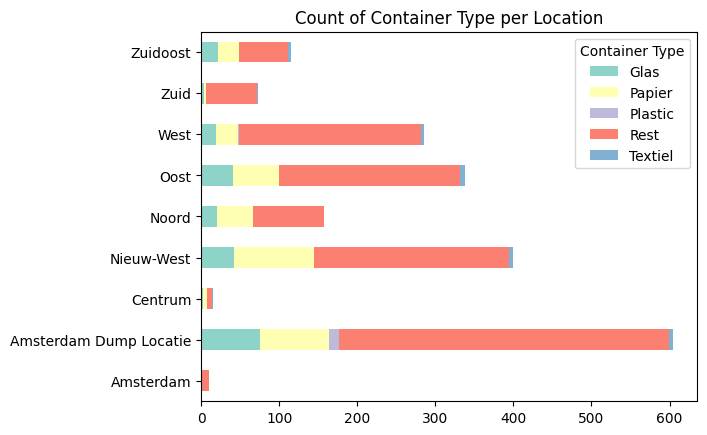

In [328]:
count_data.plot(kind='barh', stacked=True, color=['#8dd3c7', '#ffffb3', '#bebada', '#fb8072', '#80b1d3'])
plt.xlabel('')
plt.ylabel('')
plt.title('Count of Container Type per Location')
plt.legend(title='Container Type')
plt.show()

## Bar Chart of Active and Inactive Containers

In [128]:
count_data2 = container[container.status != 2]

In [129]:
count_data2 = count_data2.groupby('eigenaarNaam')['status'].value_counts().unstack(fill_value=0)

In [130]:
count_data2

status,0,1
eigenaarNaam,,
A Centrum,0,15
Amsterdam Dump Locatie,605,0
E West,10,276
F Nieuw-West,12,388
K Zuid,1,72
M Oost,11,327
N Noord,5,149
Stadswerken Amsterdam,5,5
T Zuidoost,1,114


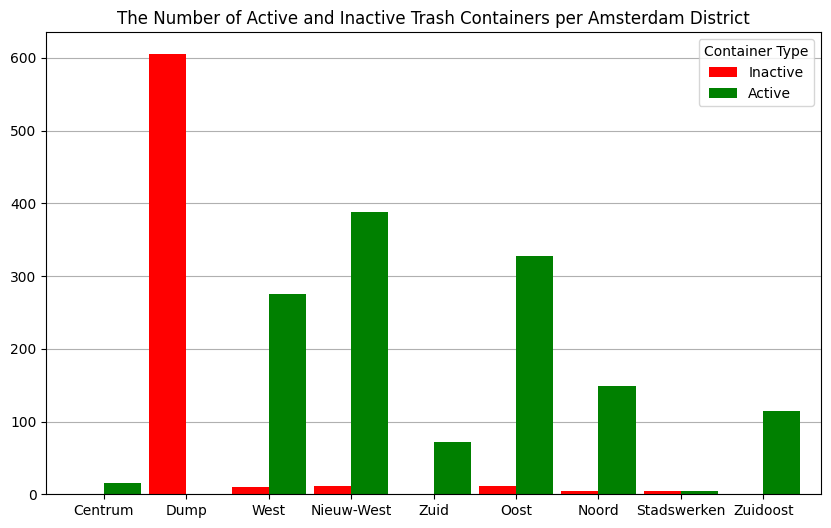

In [133]:
count_data2.plot(kind='bar', stacked=False, color=['r', 'g'], zorder = 2, width = 0.9)
plt.grid(axis='y', zorder=1)
plt.xlabel('')
plt.ylabel('')
plt.title('The Number of Active and Inactive Trash Containers per Amsterdam District')
plt.legend(title='Container Type', labels = {'Inactive': 0, 'Active': 1, 'Scheduled': 2})
plt.xticks(ticks=range(len(count_data2.index)), labels=['Centrum', 'Dump', 'West', 'Nieuw-West', 'Zuid', 'Oost', 'Noord',
          'Stadswerken', 'Zuidoost'], rotation = 0)
plt.gcf().set_size_inches(10, 6)
plt.show()

## Table of Container Lifespan per District

There are a lot of missing values in the ``datumOperationeel`` and the ``datumAflopenGarantie`` variables, but when we investigate virtually all of these are from inactive containers. Therefore this variable can still be used for analyses involving only active containers (albeit with the loss of 12 data points). 

In [126]:
container[container.datumOperationeel.isna()].status.value_counts()

0    240
2      3
1      1
Name: status, dtype: int64

In [144]:
container[container.datumAflopenGarantie.isna()].status.value_counts()

0    160
1      5
2      3
Name: status, dtype: int64

In [291]:
lifecycle = container[(~container.datumOperationeel.isna()) & (~container.datumAflopenGarantie.isna()) & (container.status != 0)]

In [292]:
date_format = "%d/%m/%Y"

In [293]:
lifecycle['datumOperationeel'] = lifecycle.datumOperationeel.apply(lambda x: datetime.strptime(x, date_format))
lifecycle['datumAflopenGarantie'] = lifecycle.datumAflopenGarantie.apply(lambda x: datetime.strptime(x, date_format))

In [294]:
lifecycle['datumAflopenGarantie'].dtype

dtype('<M8[ns]')

In [295]:
lifecycle.datumOperationeel.dtype

dtype('<M8[ns]')

In [296]:
lifecycle['difference'] = (lifecycle.datumOperationeel - lifecycle.datumAflopenGarantie).abs()
lifecycle['difference'] = lifecycle.difference.apply(lambda x: x.days)
lifecycle['difference'] = lifecycle['difference'].values.astype(int)

In [297]:
grouped_mean = lifecycle.groupby('eigenaarNaam')['difference'].mean().round(2).reset_index().rename(columns = {"eigenaarNaam": "District", "difference": "Avg. Container Lifespan in Days"})
grouped_mean.set_index('District', inplace=True)
grouped_mean

,Avg. Container Lifespan in Days
District,
A Centrum,2201.20
E West,2416.16
F Nieuw-West,2415.76
K Zuid,2413.67
M Oost,1455.10
N Noord,2283.79
Stadswerken Amsterdam,1527.83
T Zuidoost,2130.79


## Linegraph with Cumulative Count of Active Containers

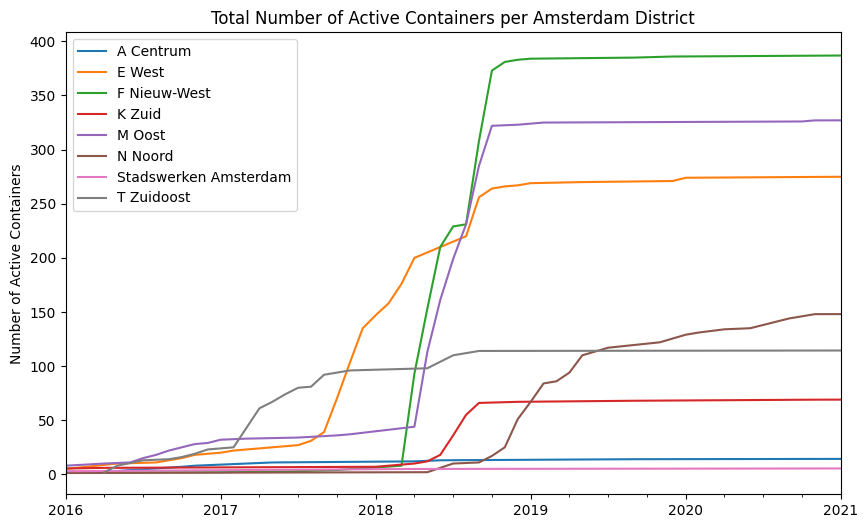

In [337]:
fig, ax = plt.subplots(figsize=(10, 6))
for category, data in lifecycle.groupby('eigenaarNaam'):
    data.groupby(data['datumOperationeel'].dt.to_period('M')).size().cumsum().plot(ax=ax, label=category)
ax.set_xlim(pd.Timestamp('2016-01-01'), '2021-01-01')
ax.set_title('Total Number of Active Containers per Amsterdam District')
ax.set_xlabel('')
ax.set_ylabel('Number of Active Containers')
ax.legend()
plt.show()